In [2]:
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# read in words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [4]:
# build vocabulary of characters and mapping to/from integers
chars = sorted(set(''.join(words)))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos, vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'} 27


In [280]:
# build dataset
block_size = 3

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for char in w + '.':
            ix = stoi[char]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [281]:
# utility function to compare manual gradients to PyTorch gradients
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [282]:
n_emb = 10
n_hidden = 64

g = torch.Generator().manual_seed(10)
C = torch.randn((vocab_size, n_emb), generator=g)
# Layer 1
W1 = torch.randn((n_emb * block_size, n_hidden), generator=g) * (5/3) / ((n_emb * block_size) ** 0.5) # (5fan_in/3)
b1 = torch.randn(n_hidden, generator=g) * 0.1# this is useless because of BatchNorm
# Layer 2
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden)) * 0.1 + 0.1
bnbias = torch.randn((1, n_hidden)) * 0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


4137


In [283]:
batch_size = 32

ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [284]:
# forward pass
emb = C[Xb]
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors

# Linear layer
hprebn = embcat @ W1 + b1 # hidden layer pre-activation

# BatchNorm layer
bnmeani = (1.0 / batch_size) * hprebn.sum(0, keepdim=True) 
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = (1.0 / (batch_size-1)) * bndiff2.sum(0, keepdim=True) 
bnvar_inv = (bnvar + 1e-5) ** -0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias

# Non-linearity
h = torch.tanh(hpreact) # hidden layer

# Linear layer 2
logits = h @ W2 + b2 # output layer

# cross entropy loss
logits_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logits_maxes # subtract max for numerical stability, don't want to exponentiate large values
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdim=True)
counts_sum_inv = counts_sum ** -1
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(batch_size), Yb].mean()

# PyTorch backward pass
for p in parameters:
    p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, norm_logits, logits_maxes, 
         logits, h, hpreact, bnraw, bnvar_inv, bnvar, bndiff2, bndiff, bnmeani, hprebn,
         embcat, emb]:
    t.retain_grad()
loss.backward()
loss

tensor(3.3492, grad_fn=<NegBackward0>)

In [285]:
# Exercise 1: backprop through the whole thing manually, 
# backpropagating through exactly all of the variables 
# as they are defined in the forward pass above, one by one

dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(batch_size), Yb] = -1.0 / batch_size
# loss = -a/3 - b/3 - c/3
dprobs = dlogprobs * (1.0 / probs)

dcounts_sum_inv = (dprobs * counts).sum(1, keepdims=True)
# c = a * b
# a[3x3] * b[3,1]
# a11*b1 a12*b1 a13*b1
# a21*b2 a22*b2 a23*b3
# a31*b3 a32*b3 a33*b3
# c[3x3]

dcounts_sum = -dcounts_sum_inv * counts_sum**-2

dcounts = dprobs * counts_sum_inv + dcounts_sum

dnorm_logits = dcounts * norm_logits.exp()

dlogits_maxes = -dnorm_logits.sum(1, keepdims=True)
# c[3x3] = a[3x3] - b[3x1]
# c11 c12 c13 = a11 - b1 a21 - b2 a31 - b3 
# c21 c22 c23 = a21 - b1 a22 - b2 a23 - b3
# c31 c32 c33 = a31 - b1 a32 - b2 a33 - b3
# because the b is broadcasted, during backward pass we need to sum all nodes it was forwarded to

dlogits = dnorm_logits.clone() + dlogits_maxes * F.one_hot(logits.max(1).indices, num_classes=logits.shape[1])

dh = dlogits @ W2.T

dW2 = h.T @ dlogits

db2 = dlogits.T.sum(1, keepdim=False)

dhpreact = (1 - torch.tanh(hpreact)**2) * dh

dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
# c = a[1,3] * b[3,3]
# a11*b11 a12*b12 a13*b13
# a21*b11 a22*b12 a23*b13
# a31*b11 a32*b12 a33*b13

dbnbias = dhpreact.sum(0, keepdim=True)

dbnraw = dhpreact * bngain

dbnvar_inv = (dbnraw * bndiff).sum(0, keepdim=True)

dbnvar = dbnvar_inv * (-0.5 * (bnvar + 1e-5)**-1.5)

dbndiff2 = dbnvar * (1.0 / (batch_size - 1)) * torch.ones_like(bndiff2)
# a[2x2].sum(0) / (n-1) --> b[2x1]
# a11 a12      b1 = (a11 + a21) / (n-1) 
# a21 a22      b2 = (a21 + a22) / (n-1)
# if there is a sum in the forward pass, it becomes a broadcast in the backward pass

dbndiff = (2.0 * bndiff * dbndiff2) + (bnvar_inv * dbnraw)

dbnmeani = (-1.0 * dbndiff).sum(0, keepdim=True)

dhprebn = (1.0 / batch_size) * torch.ones_like(hprebn) * dbnmeani + dbndiff

dembcat = dhprebn @ W1.T

dW1 = embcat.T @ dhprebn

db1 = dhprebn.sum(0, keepdim=False)

demb = dembcat.view(embcat.shape[0], block_size, -1)

dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]
#print(C.shape, Xb.shape, emb.shape, Xb[:5])
       
cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogits_maxes, logits_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

In [286]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.3491969108581543 diff: 0.0


In [287]:
# backward pass

# derive equation on paper of dloss/dlogits
# comes out to when i = y, result is p_i, and when i != y, result is p_i - 1, where p_i is softmax of i-th logit
# the final loss for this batch is the loss for each example, summed up and divided by batch size

dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n

cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

logits          | exact: False | approximate: True  | maxdiff: 6.6356733441352844e-09


In [288]:
F.softmax(logits, 1)[0]

tensor([0.0297, 0.0361, 0.0437, 0.0332, 0.0320, 0.0457, 0.0491, 0.0469, 0.0326,
        0.0349, 0.0441, 0.0372, 0.0339, 0.0378, 0.0318, 0.0325, 0.0534, 0.0320,
        0.0310, 0.0324, 0.0393, 0.0417, 0.0447, 0.0271, 0.0309, 0.0341, 0.0322],
       grad_fn=<SelectBackward0>)

In [289]:
dlogits[0] * batch_size

tensor([ 0.0297,  0.0361,  0.0437,  0.0332,  0.0320,  0.0457,  0.0491,  0.0469,
         0.0326,  0.0349,  0.0441,  0.0372,  0.0339,  0.0378,  0.0318, -0.9675,
         0.0534,  0.0320,  0.0310,  0.0324,  0.0393,  0.0417,  0.0447,  0.0271,
         0.0309,  0.0341,  0.0322], grad_fn=<MulBackward0>)

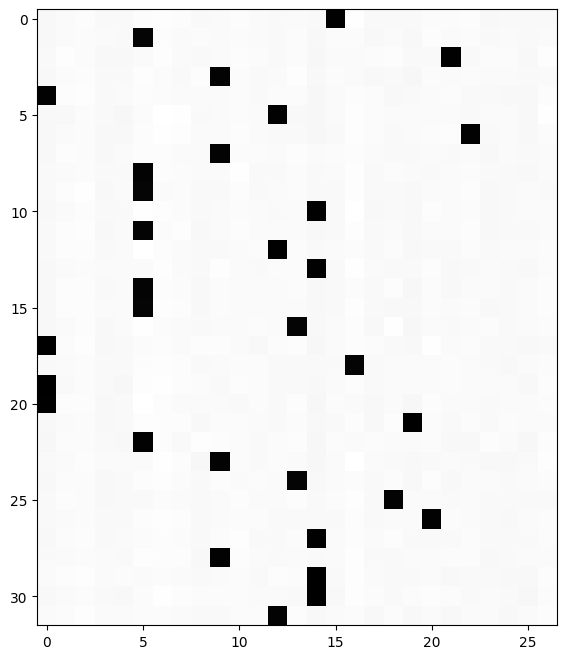

In [290]:
plt.figure(figsize=(8,8))
plt.imshow(dlogits.detach(), cmap='gray')

In [291]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out
# BatchNorm paper: https://arxiv.org/abs/1502.03167

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(1.1921e-07, grad_fn=<MaxBackward1>)


In [292]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

# -----------------
# YOUR CODE HERE :)
n = batch_size
dhprebn = bngain*bnvar_inv/n * (n * dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
# -----------------

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

hprebn          | exact: False | approximate: True  | maxdiff: 2.0372681319713593e-10


In [ ]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

    # kick off optimization
    for i in range(max_steps):

        # minibatch construct
        ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
        Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

        # forward pass
        emb = C[Xb] # embed the characters into vectors
        embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
        # Linear layer
        hprebn = embcat @ W1 + b1 # hidden layer pre-activation
        # BatchNorm layer
        # -------------------------------------------------------------
        bnmean = hprebn.mean(0, keepdim=True)
        bnvar = hprebn.var(0, keepdim=True, unbiased=True)
        bnvar_inv = (bnvar + 1e-5)**-0.5
        bnraw = (hprebn - bnmean) * bnvar_inv
        hpreact = bngain * bnraw + bnbias
        # -------------------------------------------------------------
        # Non-linearity
        h = torch.tanh(hpreact) # hidden layer
        logits = h @ W2 + b2 # output layer
        loss = F.cross_entropy(logits, Yb) # loss function

        # backward pass
        for p in parameters:
            p.grad = None
        #loss.backward() # use this for correctness comparisons, delete it later!

        # manual backprop! #swole_doge_meme
        # -----------------
        dlogits = F.softmax(logits, 1)
        dlogits[range(n), Yb] -= 1
        dlogits /= n
        # 2nd layer backprop
        dh = dlogits @ W2.T
        dW2 = h.T @ dlogits
        db2 = dlogits.sum(0)
        # tanh
        dhpreact = (1 - h**2) * dh
        # batchnorm
        dbnbias = dhpreact.sum(0, keepdim=True)
        dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
        dhprebn = bngain*bnvar_inv/n * (n * dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
        # 1st layer backprop
        dembcat = dhprebn @ W1.T
        dW1 = embcat.T @ dhprebn
        db1 = dhprebn.sum(0)
        # embedding
        demb = dembcat.view(embcat.shape[0], block_size, -1)
        dC = torch.zeros_like(C)
        for k in range(Xb.shape[0]):
            for j in range(Xb.shape[1]):
                ix = Xb[k,j]
                dC[ix] += demb[k,j]
        grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
        # -----------------

        # update
        lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
        for p, grad in zip(parameters, grads):
            #p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
            p.data += -lr * grad # new way of swole doge TODO: enable

        # track stats
        if i % 10000 == 0: # print every once in a while
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
            lossi.append(loss.log10().item())

    #     if i >= 100: # delete early breaking when you're ready to train the full net
    #         break

12297
      0/ 200000: 3.6694
  10000/ 200000: 2.4936
  20000/ 200000: 2.3621
  30000/ 200000: 2.1136
  40000/ 200000: 2.0519
  50000/ 200000: 2.4424
  60000/ 200000: 2.2511
  70000/ 200000: 2.0556
  80000/ 200000: 1.9407
  90000/ 200000: 2.0401
 100000/ 200000: 2.3752
 110000/ 200000: 2.1806
 120000/ 200000: 2.1162
 130000/ 200000: 2.4088
 140000/ 200000: 2.2800
 150000/ 200000: 2.2913
 160000/ 200000: 2.0957
 170000/ 200000: 1.9662
 180000/ 200000: 2.3081
 190000/ 200000: 1.8671


In [298]:
# useful for checking your gradients
# for p,g in zip(parameters, grads):
#     cmp(str(tuple(p.shape)), g, p)

(27, 10)        | exact: False | approximate: True  | maxdiff: 2.0489096641540527e-08
(30, 200)       | exact: False | approximate: True  | maxdiff: 9.313225746154785e-09
(200,)          | exact: False | approximate: True  | maxdiff: 4.6566128730773926e-09
(200, 27)       | exact: False | approximate: True  | maxdiff: 1.4901161193847656e-08
(27,)           | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09
(1, 200)        | exact: False | approximate: True  | maxdiff: 1.862645149230957e-09
(1, 200)        | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09


In [ ]:
# calibrate the batch norm at the end of training
with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [ ]:
# evaluate train and val loss
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = { 'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass
        emb = C[torch.tensor([context])] # (1,block_size,d)      
        embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
        hpreact = embcat @ W1 + b1
        hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
        h = torch.tanh(hpreact) # (N, n_hidden)
        logits = h @ W2 + b2 # (N, vocab_size)
        # sample
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

To get an idea of how to compute the gradients, first check tensor shapes, then write out the relationship between variables.
1) When a node is forward passed to multiple nodes, the backward pass of this node sums all outgoing gradients.
2) If a tensor is broadcasted in the forward pass, it will be summed in the backward pass. Similarly, if a tensor is summed in the forward pass, it will be broadcasted in the backward pass.

Inuition behind dlogits: think of each element in an example as a force; the incorrect elements get pulled down and the correct element gets pushed up. The total amount of force sums to zero per row in dlogits, it just gets re-allocated. Metaphor: neural net is like a massive pulley system. Each iteration, the correct examples get pushed up, the wrong ones get pushed down, and these mechanistically change the weights and biases to support the new logits.
    * If probabilities out of forward pass came out exactly correct, i.e. zeros everywhere and a one in the correct  position, dlogits of this row would have zeros everywhere. Intuitively there is no push or pull required because the probabilities are correct. Conversely, if we have a very confident mis-prediction, that element will be pulled down heavily and the correct element will be pushed up with an equal amount of force.